## Домашнее задание №3. Новопольский Артём

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare
from scipy.stats import shapiro, levene
sns.set(palette='bright')

### Описание кейса

1. На сайте проводится некоторый эксперимент. Время проведения эксперимента – *2 недели*. Всего на сайте **DAU** около *500 000* и **WAU** около *850 000*. Всего за время работы на сайте образовалась аудитория из около *1 500 000* не уходящих в отток посетителей.


2. В файле данные о результатах эксперимента. В колонке `group_id` вы видите bucket’ы с номерами *от 1 до 16*. К группе `A`, контрольной, относятся bucket’ы *1..8*, к группе `B`, экспериментальной – *9..16*. Колонки:
- `metric_value` – сумма целевых действий пользователей в рамках bucket’а – например, просмотров рекламного баннера, телефона на сайте classified-сервиса или покупок в retail/FMCG;
- `users` – кол-во пользователей, совершивших целевое действие, 
- `visits` – кол-во целевых сессий,
- `churn_users` и `churn_visits` – кол-во пользователей в рамках bucket’а, отказавшихся сделать заказ, и сессий, не закончившихся успешным целевым действием.

3. Менеджера продукта интересует, какие **позитивные** и **негативные** эффекты вызвало нововведение. Продумайте **метрики**, которые стоит исследовать в рамках имеющихся данных для ответа на вопрос менеджера.


### Описание задания

1. Загрузите данные из файла в структуру `pandas.DataFrame()`.

2. Проведите *оценку равенства дисперсий* исследуемых метрик в группах и исследуйте *распределение на нормальность*. Какими критериями вы воспользовались и почему?

3. Оцените статистическую значимость различий исследуемых метрик в выборках при помощи библиотеки `bootstrapped`. 

4. Изобразите *гистограммы* и *диаграммы размаха*.

5. Результат работы пришлите в формате *IPython Jupyter Notebook* на сервисе *Google Colab*.

## Импорт данных

In [2]:
user_data = pd.read_csv('../data/hw_ab_test.csv', sep='\t', index_col=0)
user_data.head()

,group_id,metric_value,users,visits,churn_users,churn_visits,group
0,8,6630.000,0,0,0,8,A
1,13,6933.976,0,0,1,6,B
2,10,8261.976,1,10,1,8,B
3,4,5522.000,1,9,1,7,A
4,16,5075.976,1,6,0,8,B


Убедимся, что в нашем наборе данных отсутствуют пропущенные значения:

In [3]:
user_data.isna().values.sum() == 0

True

Посмотрим, сколько пользователей содержится в контрольной и тестовой группах, чтобы удостовериться, что количество наблюдений сбалансировано:

In [4]:
print('Control group size:', len(user_data.loc[user_data.group == 'A']), 
      '\nTest group size:', len(user_data.loc[user_data.group == 'B']))

Control group size: 2451 
Test group size: 2549


## Графический анализ данных

Начнём исследование с **визуализации данных**. Для этого произведём разбиение данных по контрольной и тестовой группам.

In [5]:
control = user_data.loc[user_data.group == 'A']
test = user_data.loc[user_data.group == 'B']

Для визуализации создадим функцию - `show_plots`, которая будет принимать на вход данные для контрольной и тестовой групп, а также метрики, которые нужно визуализировать.

Функция будет отображать два графика для каждой метрики - **гистограмму** метрики в контрольной и тестовой группах, а также **диаграмму размаха** (box-plot) метрики в контрольной и тестовой группах.

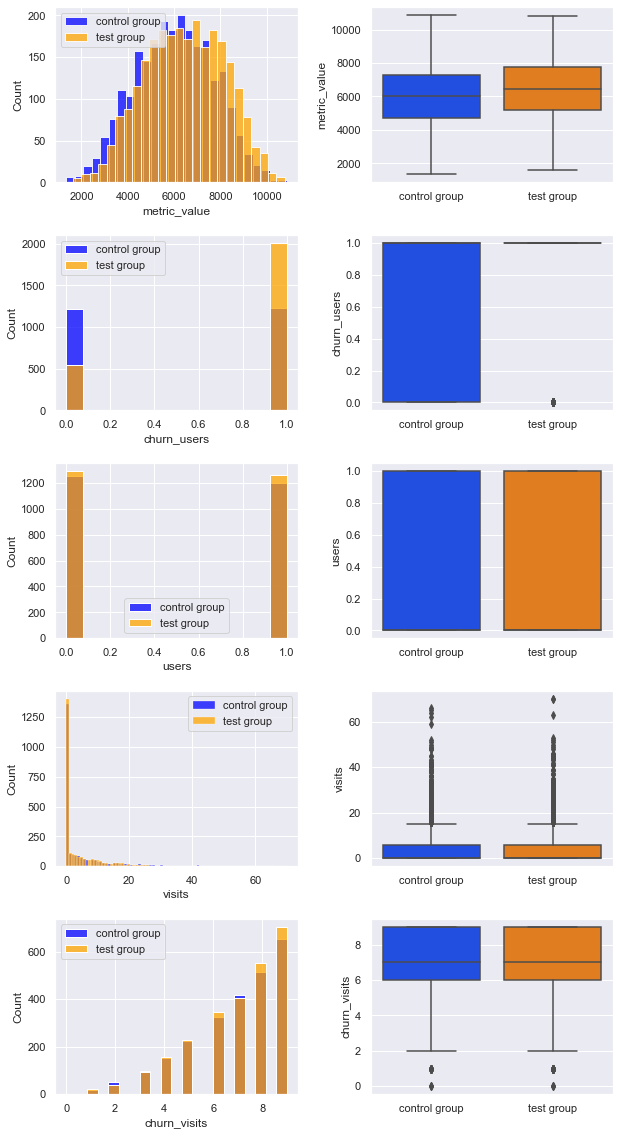

In [6]:
def show_plots(control, test, metrics):
    fig, axes = plt.subplots(len(metrics), 2, figsize=(10, 20))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    for i, metric in enumerate(metrics):
        sns.histplot(control[metric], ax=axes[i, 0], label='control group', color='blue')
        sns.histplot(test[metric], ax=axes[i, 0], label='test group', color='orange')
        axes[i, 0].legend()
        
        sns.boxplot(data=[control[metric], test[metric]], ax=axes[i, 1]).set(
            xticklabels=['control group', 'test group'], 
            ylabel=metric,
        )
    plt.show()

metrics = ['metric_value', 'churn_users', 'users', 'visits', 'churn_visits']
show_plots(control, test, metrics)

### Интерпретация графиков

По полученным графикам видно, что только распределение метрики `metric_value` чем-то напоминает нормальное, так что имеет смысл его исследовать при помощи статистического теста. Остальные метрики явно имеют распределения, отличные от нормального. 

Также по графикам заметно, что данные `metric_value` в тестовой группе смещены относительно контрольной. А на гистограмме метрики `churn_users` видно, как сильно отличаются значения в тестовой и контрольной группах. Полученные визуализации дают почву для более глубокого анализа изменения метрик `metric_value` и `churn_users`.

Оставшиеся метрики `users`, `visits`, `churn visits`, как можно увидеть по *box-plot'ам* и *гистограммам*, не претерпели серьёзных изменений.

## Проверка данных на нормальность

Проверим предположение о нормальности распределения `metric_value` с помощью **критерия Шапиро-Уилка**. Его нулевая гипотеза заключается в том, что выборка имеет нормальное распределение.

Данный критерий был выбран из-за того, что обладает большей мощностью (способностью не допустить ошибку 2-го рода, то есть ложно принять нулевую гипотезу), чем, например, непараметрические критерии Колмогорова-Смирнова и Андерсена-Дарлинга.

In [7]:
def calc_shapiro_wilk_test(control, test):
    control_res = shapiro(control)
    test_res = shapiro(test)
    return control_res, test_res

alpha = 0.05
metric_value_res = calc_shapiro_wilk_test(control['metric_value'], test['metric_value'])

print('Распределение metric_value в контрольной группе:',
      ('нормальное. H0 принята.' if metric_value_res[0][1] > alpha else 'отличное от нормального. H0 отвергнута.'), 
      '\nРаспределение metric_value в тестовой группе:',
      ('нормальное. H0 принята.' if metric_value_res[1][1] > alpha else 'отличное от нормального. H0 отвергнута.'))

Распределение metric_value в контрольной группе: отличное от нормального. H0 отвергнута. 
Распределение metric_value в тестовой группе: отличное от нормального. H0 отвергнута.


Используя тест Шапиро-Уилка, мы не смогли принять нулевую гипотезу о нормальности распределения `metric_value`. Теперь можем утверждать, что распределения всех наших метрик имеет вид, отличный от нормального. 

## Оценка равенства дисперсий

Проверим, равны ли дисперсии у групп с помощью **критерия Левена**. Данный критерий был выбран из-за своей универсальности (может оценивать равенство дисперсий 2-х и более выборок), а также из-за того, что он менее чувствителен к отклонению распределения от нормального, чем, например, критерий Бартлетта. 

Нулевая гипотеза критерия предполагает, что рассматриваемые выборки получены из генеральных совокупностей, обладающих одинаковыми дисперсиями.

In [8]:
alpha = 0.05
metric_value_res = levene(control['metric_value'], test['metric_value'])
print('Дисперсии metric_value у контрольной и тестовой групп:',
      ('равны. H0 принята.' if metric_value_res[1] > alpha else 'не равны. H0 отвергнута.'))

Дисперсии metric_value у контрольной и тестовой групп: равны. H0 принята.


С помощью критерия Левена мы убедились, что дисперсии `metric_value` в группах равны. 

Однако из-за того, что распределения всех метрик имеет вид, отличный от нормального, мы не можем применить классические методы оценки статистической значимости, как **t-test**. Поэтому для оценки нашего эксперимента мы воспользуемся методом **bootstrap**.

## Оценка статистической значимости различий 

Наконец, можем перейти к статистической оценке значимости различий метрик в контрольной и тестовых группах. Так как распределения метрик отличны от нормального, то для этого мы воспользуемся методом **bootstrap**.

В качестве статистики будем использовать среднее (`stat_func=bs_stats.mean`) и будем вычислять разности (`compare_func=bs_compare.difference`). На выходе получим доверительный интервал для разности средних в тестовой и контрольной группах. Соответственно, если доверительный интервал не будет включать в себя 0, то можем считать различия в группах статистически значимыми.

In [9]:
bs.bootstrap_ab(test['metric_value'].values, 
                control['metric_value'].values, 
                stat_func=bs_stats.mean,
                compare_func=bs_compare.difference,
                alpha=0.05,
                num_iterations=10000,
                iteration_batch_size=100)

432.82458935408613    (339.6375251154875, 526.9511316905898)

Так как доверительный интервал для разности средних метрики `metric_value` **не включает** в себя 0, то средние в группах значимо отличаются. Также заметим, что значения в интервале больше нуля, то есть в тестовой группе метрика значимо **выросла**.

In [10]:
bs.bootstrap_ab(test['churn_users'].values, 
                control['churn_users'].values, 
                stat_func=bs_stats.mean,
                compare_func=bs_compare.difference,
                alpha=0.05,
                num_iterations=10000,
                iteration_batch_size=100)

0.282722690748878    (0.257646337416982, 0.30792492443897235)

Доверительный интервал для разности средних метрики `churn_users` тоже **не включает** в себя 0, следовательно, средние в группах значимо отличаются. Значения в интервале больше нуля, то есть в тестовой группе метрика значимо **выросла**.

In [11]:
bs.bootstrap_ab(test['users'].values, 
                control['users'].values, 
                stat_func=bs_stats.mean,
                compare_func=bs_compare.difference,
                alpha=0.05,
                num_iterations=10000,
                iteration_batch_size=100)

0.006724023100714405    (-0.02091066103954487, 0.03440694577228798)

Для разности средних метрики `users` доверительный интервал **включает** в себя 0, поэтому можем сделать вывод, что средние в группах значимо не отличаются.

In [12]:
bs.bootstrap_ab(test['visits'].values, 
                control['visits'].values, 
                stat_func=bs_stats.mean,
                compare_func=bs_compare.difference,
                alpha=0.05,
                num_iterations=10000,
                iteration_batch_size=100)

-0.2857145601054105    (-0.7590945337560882, 0.18023831235007204)

Доверительный интервал для разности средних метрики `visits` **включает** в себя 0, то есть средние в группах значимо не отличаются.

In [13]:
bs.bootstrap_ab(test['churn_visits'].values, 
                control['churn_visits'].values, 
                stat_func=bs_stats.mean,
                compare_func=bs_compare.difference,
                alpha=0.05,
                num_iterations=10000,
                iteration_batch_size=100)

0.050967899828398444    (-0.055457624601065625, 0.15634354493622335)

*Доверительный* интервал для разности средних метрики `churn_visits` также **включает** в себя 0, что говорит о том, что средние в группах значимо не отличаются.

Результаты метода **bootstrap**, как и результаты стандартных методов оценки статистической значимости, применённых в предыдущей работе, позволяют нам заявить о том, что эксперимент значимо повлиял на метрики `metric_value` и `churn_users`. Метрики `users`, `visits`, `churn visits` значимо не изменились.

## Заключение

Осталось ответить на самый главный вопрос - **какие позитивные и негативные эффекты вызвало нововведение**.

Стоит начать с того, что значение целевой метрики `metric_value`, на которую был нацелен эксперимент, значимо увеличилось, что является *позитивным эффектом* проведенного A/B-теста.

Однако у полученного результата есть и обратная сторона, которая заключается в том, что при росте целевой метрики мы получили значимое увеличение кол-ва пользователей, ушедших в отток (`churn_users`).

В долгосрочной перспективе это окажет негативное влияние на сервис - из-за нелояльных пользователей будет снижаться репутация сервиса, а также метрики *DAU* и *WAU*, что отрицательно отразится на финансовых показателях.

Возможно, новое решение "агрессивно" что-то навязывает. Поэтому необходимо понять, чем новые фичи могли не устроить пользователей. Следует скорректировать текущее решение так, чтобы сбалансировать выгоду сервиса и лояльность пользователей. И в идеале провести тест ещё раз.

В текущем виде катить не стоит, так как различия в `churn_users` выражены гораздо сильнее, чем прирост `metric_value` (это можно понять, исходя из построенных графиков и рассчитанных объёмов выборок, необходимых для получения статистически значимых результатов). Значимо терять пользователей из-за роста метрики не стоит.